### The Impact of Sequence Length on Prediction Performance

In [ ]:
from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
from darts.datasets import EnergyDataset
from darts import concatenate


In [ ]:
import time

from statsmodels.datasets import co2
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.seasonal import STL
import numpy as np
import copy
from sklearn.preprocessing import StandardScaler

import matplotlib.font_manager as fm
import seaborn as sns

In [ ]:
import os
os.environ['OMP_NUM_THREADS'] = '4'

from data1.serialize import SerializerSettings
from data1.small_context import get_datasets,get_memorization_datasets

In [ ]:
from models.utils import grid_iter
from models.validation_likelihood_tuning import get_autotuned_predictions_data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from models import llmtime
from models.llmtime import get_llmtime_predictions_data

In [ ]:
import pickle
import json

In [ ]:
import openai

with open('config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

openai.api_key = config['OPENAI_API_KEY']
openai.api_base = config['OPENAI_API_BASE']

In [ ]:
# `model_predict_fns` and `model_names` represent the set of models used. These are referenced within the function, 
# but are defined externally.

def prediction_gemini(model_predict_fns, train, test, model_hypers, num_samples=10, whether_blanket=False, dataset_name='WineDataset'):
    model_names = list(model_predict_fns.keys())
    out_gemini_pro = {}  # gemini-pro
    out_gemini_pro_number = {}  # gemini-1.0-pro
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})  
        hypers = list(grid_iter(model_hypers[model])) 
        
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False, whether_blanket=whether_blanket) 
        if model == 'gemini-pro':
            out_gemini_pro.update({dataset_name: pred_dict})
        if model == 'gemini-1.0-pro':
            out_gemini_pro_number.update({dataset_name: pred_dict})
    return out_gemini_pro, out_gemini_pro_number

##### WineDataset

In [ ]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data, 
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

train, test = datasets['WineDataset']
dataset_name = 'WineDataset'

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [8]:
def fig_length(metric, metric_name='R^2', dataset_name='WineDataset'):
    font_path = fm.findfont(fm.FontProperties(family='Times New Roman'))
    font_prop = fm.FontProperties(fname=font_path)
    _font_size = 38
    sns.set_style('whitegrid')
    sns.set(style="whitegrid", rc={"axes.grid.axis": "y", "axes.grid": True})
    fig = plt.figure(figsize=(12,8))
    ax1 = plt.gca()
    x = np.arange(len(metric))
    sns.lineplot(x=x, y=metric, color='#d37981', alpha=1, linewidth=5, marker='o',markerfacecolor='w',markeredgecolor='#d37981', markersize=6)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    plt.xlabel("Index", fontproperties=font_prop, fontsize=_font_size+5)
    plt.ylabel(metric_name, fontproperties=font_prop, fontsize=_font_size+5)
    plt.legend(bbox_to_anchor=(0.5, 1.4), loc='upper center',fontsize=_font_size)
    plt.tight_layout()
    plt.savefig(f"Length_of_Training_Set Analysis_0407_{dataset_name}.png")
    plt.show()

In [ ]:
n = 1  # 表示减少的周期长度数
period = 12
all_rounds = int(len(train)/period)

output_ = []  # 记录是否有该现象

for index in range(0, all_rounds):  # WineDataset 来做预测, 12 是其真实 (提前给定的) 周期
    print('Round:', index)
    train_tmp = copy.deepcopy(train)
    test_tmp = copy.deepcopy(test)
    train_tmp = train_tmp.iloc[(index*period):]
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': 'WineDataset'})  # for promptcast, dict 添加元素
        hypers = list(grid_iter(model_hypers[model]))  # 简单理解为传参
        num_samples = 10  # 表示重复的预测的次数, 此处只是为了得到 prec
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test_tmp, model_hypers, num_samples=10, whether_blanket=False)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test_tmp, seq_pred)
        mae = mean_absolute_error(test_tmp, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test_tmp, seq_pred)*100
        r2 = r2_score(test_tmp, seq_pred)
    
        mse_amount += mse
        mae_amount += mae
        mape_amount += mape
        rsquare_amount += r2
    
    mse_mean = mse_amount/num_samples
    mae_mean = mae_amount/num_samples
    mape_mean = mape_amount/num_samples
    r2_mean = rsquare_amount/num_samples
    
    # print and plot values
    print("\n")
    print('round:', index)
    print(f'MSE: {mse_mean}, MAE: {mae_mean}, MAPE: {mape_mean}, R²: {r2_mean}')
    print("\n")
    
    output_.append({'index': index, 'mse': mse_mean, 'mae': mae_mean, 'mape': mape_mean, 'r2': r2_mean})

In [40]:
out_gemini_pro_number['WineDataset']['samples']

date,1991-09-01,1991-10-01,1991-11-01,1991-12-01,1992-01-01,1992-02-01,1992-03-01,1992-04-01,1992-05-01,1992-06-01,...,1993-11-01,1993-12-01,1994-01-01,1994-02-01,1994-03-01,1994-04-01,1994-05-01,1994-06-01,1994-07-01,1994-08-01
0,30705.535625,27648.303125,28085.050625,27260.083125,23766.103125,25367.510625,27405.665625,31481.975625,26944.654375,26847.599375,...,30001.886875,30171.733125,30365.843125,28036.523125,26968.918125,25464.565625,25391.774375,25755.730625,26750.544375,28643.116875
1,30341.579375,27526.984375,32379.734375,27624.039375,19544.210625,22237.486875,22188.959375,22188.959375,22188.959375,22188.959375,...,22188.959375,22188.959375,22188.959375,22188.959375,22188.959375,22188.959375,22188.959375,22188.959375,22188.959375,22188.959375
2,21266.936875,32185.624375,32452.525625,28934.281875,32403.998125,31190.810625,30438.634375,29176.919375,26168.214375,25901.313125,...,26726.280625,26726.280625,26726.280625,26726.280625,26726.280625,26726.280625,26726.280625,26726.280625,26726.280625,26726.280625
3,24275.641875,22334.541875,23838.894375,22965.399375,22747.025625,21970.585625,22674.234375,22625.706875,22601.443125,22577.179375,...,22164.695625,22140.431875,22116.168125,22091.904375,22067.640625,22043.376875,22019.113125,21994.849375,21970.585625,21946.321875
4,24372.696875,22261.750625,20078.013125,29225.446875,24906.499375,27357.138125,21727.948125,26653.489375,31020.964375,27648.303125,...,27163.028125,30438.634375,24178.586875,27721.094375,22116.168125,27090.236875,30414.370625,24251.378125,27648.303125,22091.904375
5,25367.510625,25852.785625,29492.348125,30681.271875,32306.943125,28182.105625,27478.456875,24809.444375,24955.026875,26823.335625,...,30195.996875,30511.425625,30559.953125,30632.744375,30632.744375,30681.271875,30705.535625,30729.799375,30705.535625,30657.008125
6,24882.235625,24930.763125,25100.609375,25124.873125,25149.136875,25173.400625,25197.664375,25221.928125,25246.191875,25270.455625,...,25682.939375,25707.203125,25731.466875,25755.730625,25779.994375,25804.258125,25828.521875,25852.785625,25877.049375,25901.313125
7,29055.600625,31748.876875,28594.589375,24008.740625,22043.376875,21339.728125,20951.508125,22116.168125,25173.400625,29443.820625,...,32501.053125,32476.789375,32452.525625,32428.261875,32403.998125,32379.734375,32355.470625,32331.206875,32306.943125,32282.679375
8,27332.874375,29953.359375,31627.558125,13454.009375,26702.016875,25027.818125,29759.249375,25027.818125,27551.248125,25221.928125,...,25440.301875,20490.496875,25318.983125,25440.301875,20490.496875,25318.983125,25440.301875,20490.496875,25318.983125,25440.301875
9,25440.301875,25416.038125,25294.719375,32573.844375,35121.538125,16050.230625,22140.431875,21194.145625,19544.210625,22091.904375,...,25440.301875,25416.038125,25294.719375,32573.844375,35121.538125,16050.230625,22140.431875,21194.145625,19544.210625,22091.904375


In [41]:
output_[-1]  # 一共10个可选周期，也不短了......总不至于120是分界点吧......

{'index': 10,
 'mse': 43331427.37209271,
 'mae': 5069.289409722222,
 'mape': 20.771333587930037,
 'r2': -0.5439730728822134}

In [54]:
mape_list = []
r2_list = []
mae_list = []
for dict in output_:
    mape_list.append(dict['mape'])
    r2_list.append(dict['r2'])
    mae_list.append(dict['mae'])

def find_minimum_index(lst):
    min_value = min(lst)
    min_index = lst.index(min_value)
    return min_index

def find_maximum_index(lst):
    max_value = max(lst)
    max_index = lst.index(max_value)
    return max_index

argmin_mape = find_minimum_index(mape_list)
argmax_r2 = find_maximum_index(r2_list)

print(argmin_mape, argmax_r2)



4 0


C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


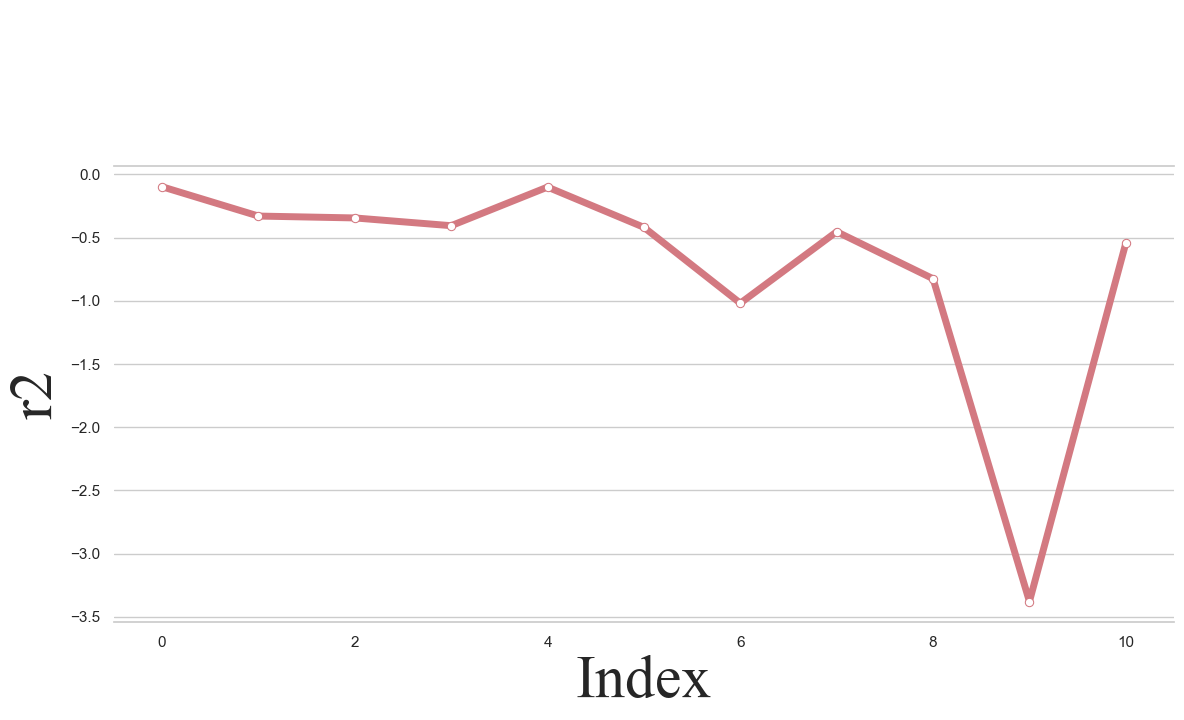

In [56]:
fig_length(metric=r2_list, metric_name='r2', dataset_name='WineDataset')

##### AirPassengersDataset

In [44]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

train, test = datasets['AirPassengersDataset']
dataset_name = 'AirPassengersDataset'

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [ ]:
n = 1  # 表示减少的周期长度数
period = 12
all_rounds = int(len(train)/period)

output_AirPassengersDataset = []  # 记录是否有该现象

for index in range(0, all_rounds):  # WineDataset 来做预测, 12 是其真实 (提前给定的) 周期
    print('Round:', index)
    train_tmp = copy.deepcopy(train)
    test_tmp = copy.deepcopy(test)
    train_tmp = train_tmp.iloc[(index*period):]
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})  # for promptcast, dict 添加元素
        hypers = list(grid_iter(model_hypers[model]))  # 简单理解为传参
        num_samples = 10  # 表示重复的预测的次数, 此处只是为了得到 prec
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test_tmp, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test_tmp, seq_pred)
        mae = mean_absolute_error(test_tmp, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test_tmp, seq_pred)*100
        r2 = r2_score(test_tmp, seq_pred)
    
        mse_amount += mse
        mae_amount += mae
        mape_amount += mape
        rsquare_amount += r2
    
    mse_mean = mse_amount/num_samples
    mae_mean = mae_amount/num_samples
    mape_mean = mape_amount/num_samples
    r2_mean = rsquare_amount/num_samples
    
    # print and plot values
    print("\n")
    print('round:', index)
    print(f'MSE: {mse_mean}, MAE: {mae_mean}, MAPE: {mape_mean}, R²: {r2_mean}')
    print("\n")
    
    output_AirPassengersDataset.append({'index': index, 'mse': mse_mean, 'mae': mae_mean, 'mape': mape_mean, 'r2': r2_mean})

In [ ]:
output_AirPassengersDataset
all_rounds 

11

In [57]:
mape_list_AirPassengersDataset = []
r2_list_AirPassengersDataset = []
mae_list_AirPassengersDataset = []
for dict in output_AirPassengersDataset:
    mape_list_AirPassengersDataset.append(dict['mape'])
    r2_list_AirPassengersDataset.append(dict['r2'])
    mae_list_AirPassengersDataset.append(dict['mae'])

def find_minimum_index(lst):
    min_value = min(lst)
    min_index = lst.index(min_value)
    return min_index

def find_maximum_index(lst):
    max_value = max(lst)
    max_index = lst.index(max_value)
    return max_index

argmin_mape = find_minimum_index(mape_list_AirPassengersDataset)
argmax_r2 = find_maximum_index(r2_list_AirPassengersDataset)

print(argmin_mape, argmax_r2)

2 0


In [60]:
len(r2_list_AirPassengersDataset)

8

C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


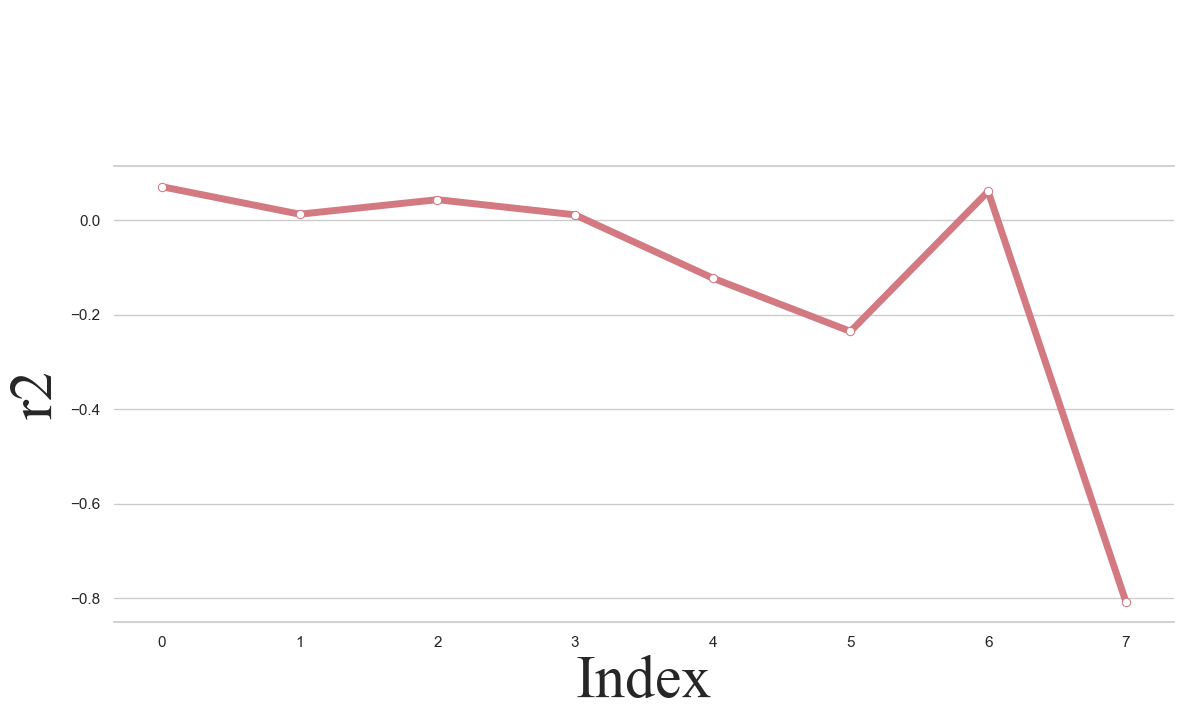

In [59]:
fig_length(metric=r2_list_AirPassengersDataset, metric_name='r2', dataset_name='AirPassengersDataset')

# 抛去一些离群点，基本可以认为随着input length上升，效果在上升 (确实长度太短了......)

##### MonthlyMilkDataset

In [46]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

train, test = datasets['MonthlyMilkDataset']
dataset_name = 'MonthlyMilkDataset'

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [ ]:
n = 1  # 表示减少的周期长度数
period = 12
all_rounds = int(len(train)/period)

output_AusBeerDataset = []  # 记录是否有该现象

for index in range(0, all_rounds):  # WineDataset 来做预测, 12 是其真实 (提前给定的) 周期
    print('Round:', index)
    train_tmp = copy.deepcopy(train)
    test_tmp = copy.deepcopy(test)
    train_tmp = train_tmp.iloc[(index*period):]
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})  # for promptcast, dict 添加元素
        hypers = list(grid_iter(model_hypers[model]))  # 简单理解为传参
        num_samples = 10  # 表示重复的预测的次数, 此处只是为了得到 prec
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test_tmp, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test_tmp, seq_pred)
        mae = mean_absolute_error(test_tmp, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test_tmp, seq_pred)*100
        r2 = r2_score(test_tmp, seq_pred)
    
        mse_amount += mse
        mae_amount += mae
        mape_amount += mape
        rsquare_amount += r2
    
    mse_mean = mse_amount/num_samples
    mae_mean = mae_amount/num_samples
    mape_mean = mape_amount/num_samples
    r2_mean = rsquare_amount/num_samples
    
    # print and plot values
    print("\n")
    print('round:', index)
    print(f'MSE: {mse_mean}, MAE: {mae_mean}, MAPE: {mape_mean}, R²: {r2_mean}')
    print("\n")
    
    output_AusBeerDataset.append({'index': index, 'mse': mse_mean, 'mae': mae_mean, 'mape': mape_mean, 'r2': r2_mean})

In [48]:
mape_list_MonthlyMilkDataset = []
r2_list_MonthlyMilkDataset = []
mae_list_MonthlyMilkDataset = []
for dict in output_AusBeerDataset:
    mape_list_MonthlyMilkDataset.append(dict['mape'])
    r2_list_MonthlyMilkDataset.append(dict['r2'])
    mae_list_MonthlyMilkDataset.append(dict['mae'])

def find_minimum_index(lst):
    min_value = min(lst)
    min_index = lst.index(min_value)
    return min_index

def find_maximum_index(lst):
    max_value = max(lst)
    max_index = lst.index(max_value)
    return max_index

argmin_mape = find_minimum_index(mape_list_MonthlyMilkDataset)
argmax_r2 = find_maximum_index(r2_list_MonthlyMilkDataset)

print(argmin_mape, argmax_r2)

0 0


C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


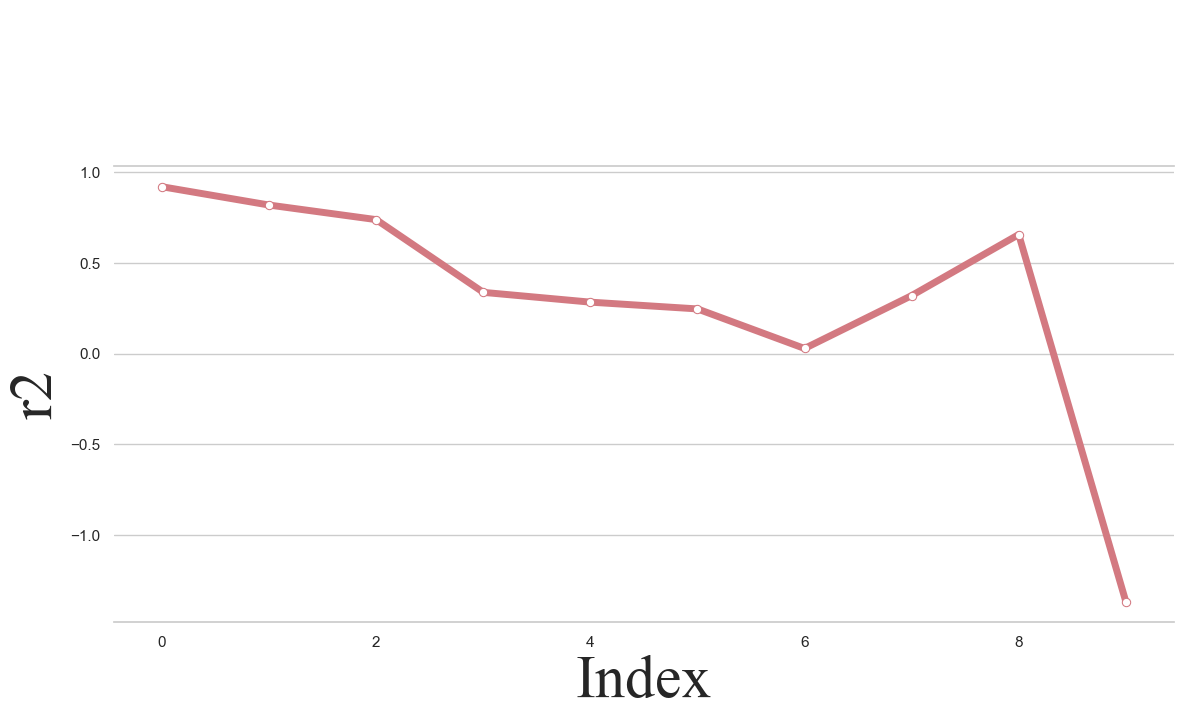

In [61]:
fig_length(metric=r2_list_MonthlyMilkDataset, metric_name='r2', dataset_name='MonthlyMilkDataset')

# 没有意义，至少在目前的长度序列来看(~300)，不会出现顶峰or最适宜的长度情况

##### GasRateCO2Dataset

In [ ]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

train, test = datasets['GasRateCO2Dataset']
dataset_name = 'GasRateCO2Dataset'

In [ ]:
n = 1  # 表示减少的周期长度数
period = 12
all_rounds = int(len(train)/period)

output_GasRateCO2Dataset = []  

for index in range(0, all_rounds):  
    print('Round:', index)
    train_tmp = copy.deepcopy(train)
    test_tmp = copy.deepcopy(test)
    train_tmp = train_tmp.iloc[(index*period):]
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})  
        hypers = list(grid_iter(model_hypers[model])) 
        num_samples = 10  
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test_tmp, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test_tmp, seq_pred)
        mae = mean_absolute_error(test_tmp, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test_tmp, seq_pred)*100
        r2 = r2_score(test_tmp, seq_pred)
    
        mse_amount += mse
        mae_amount += mae
        mape_amount += mape
        rsquare_amount += r2
    
    mse_mean = mse_amount/num_samples
    mae_mean = mae_amount/num_samples
    mape_mean = mape_amount/num_samples
    r2_mean = rsquare_amount/num_samples
    
    # print and plot values
    print("\n")
    print('round:', index)
    print(f'MSE: {mse_mean}, MAE: {mae_mean}, MAPE: {mape_mean}, R²: {r2_mean}')
    print("\n")
    
    output_GasRateCO2Dataset.append({'index': index, 'mse': mse_mean, 'mae': mae_mean, 'mape': mape_mean, 'r2': r2_mean})

In [ ]:
mape_list_GasRateCO2Dataset = []
r2_list_GasRateCO2Dataset = []
mae_list_GasRateCO2Dataset = []
for dict in output_GasRateCO2Dataset:
    mape_list_GasRateCO2Dataset.append(dict['mape'])
    r2_list_GasRateCO2Dataset.append(dict['r2'])
    mae_list_GasRateCO2Dataset.append(dict['mae'])

def find_minimum_index(lst):
    min_value = min(lst)
    min_index = lst.index(min_value)
    return min_index

def find_maximum_index(lst):
    max_value = max(lst)
    max_index = lst.index(max_value)
    return max_index

argmin_mape = find_minimum_index(mape_list_GasRateCO2Dataset)
argmax_r2 = find_maximum_index(r2_list_GasRateCO2Dataset)

print(argmin_mape, argmax_r2)

In [ ]:
fig_length(metric=r2_list_GasRateCO2Dataset, metric_name='r2', dataset_name='IstanbulTraffic')

In [ ]:
fig_length(metric=mape_list_GasRateCO2Dataset, metric_name='mape', dataset_name='IstanbulTraffic')


### Counterfactual Analysis

##### WineDataseet

In [ ]:
import time
import copy

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data, 
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

dataset_name = 'WineDataset'
train, test = datasets['WineDataset']

In [28]:
def adding_noise(train, loc=0, steps=4, std=5):
    # 噪声需要固定才有说服力
    np.random.seed(42)
    noise = np.random.normal(0, std, steps)
    train[loc:(loc+steps)] += noise
    return train

In [ ]:
period = 12
std = 0.1*(train.max()-train.min())
num_iteration = int(len(train)/period)

out_counterfactual = {}
MSE =[]
MAE =[]
MAPE = []
R = []

for index in range(num_iteration):
    MSE_tmp =[]
    MAE_tmp =[]
    MAPE_tmp = []
    R_tmp = []
    train_tmp = copy.deepcopy(train)
    loc = index * period
    train_tmp = adding_noise(train_tmp, loc=loc, steps=period, std=std)
    if index > 0:
        time.sleep(120)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)
        out_counterfactual.update(out_gemini_pro_number)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test, seq_pred)
        mae = mean_absolute_error(test, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test, seq_pred)*100
        r2 = r2_score(test, seq_pred)
    
        MSE_tmp.append(mse)
        MAE_tmp.append(mae)
        MAPE_tmp.append(mape)
        R_tmp.append(r2)
    
    MSE.append(MSE_tmp)
    MAE.append(MAE_tmp)
    MAPE.append(MAPE_tmp)
    R.append(R_tmp)



In [31]:
def plot_scatter_2d_list(data):
    m = len(data)  # 第一维的长度
    n = len(data[0])  # 第二维的长度

    # 初始化x和y坐标
    x_coords = []
    y_coords = []

    # 遍历二维列表，提取x和y坐标
    for i in range(m):
        for j in range(n):
            x_coords.append(i)  # x轴为第一维m
            y_coords.append(data[i][j])  # y轴为二维列表中的值

    # 绘制散点图
    plt.scatter(x_coords, y_coords)

def fig_counterfactual(metric, metric_name='R^2', dataset_name='WineDataset'):
    '''
    Args:
        metric: two-dimensional list 
        metric_name: 
        dataset_name: 

    Returns:

    '''
    font_path = fm.findfont(fm.FontProperties(family='Times New Roman'))
    font_prop = fm.FontProperties(fname=font_path)
    _font_size = 38
    sns.set_style('whitegrid')
    sns.set(style="whitegrid", rc={"axes.grid.axis": "y", "axes.grid": True})
    fig = plt.figure(figsize=(12,8))
    ax1 = plt.gca()
    x = np.arange(len(metric))
    metric_mean = [sum(sublist) / len(sublist) for sublist in metric]

    sns.lineplot(x=x, y=metric_mean, color='#d37981', alpha=1, linewidth=5, marker='o',markerfacecolor='w',markeredgecolor='#d37981', markersize=6)
    lower = np.quantile(metric, 0.05, axis=1)
    upper = np.quantile(metric, 0.95, axis=1)
    plt.fill_between(x, lower, upper, alpha=0.3, color='purple')
    plot_scatter_2d_list(data=metric)
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    plt.xlabel("Index", fontproperties=font_prop, fontsize=_font_size+5)
    plt.ylabel(metric_name, fontproperties=font_prop, fontsize=_font_size+5)
    plt.legend(bbox_to_anchor=(0.5, 1.4), loc='upper center',fontsize=_font_size)
    plt.tight_layout()
    plt.savefig(f"Counterfactual Analysis_0407_{dataset_name}.png")
    plt.show()

C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


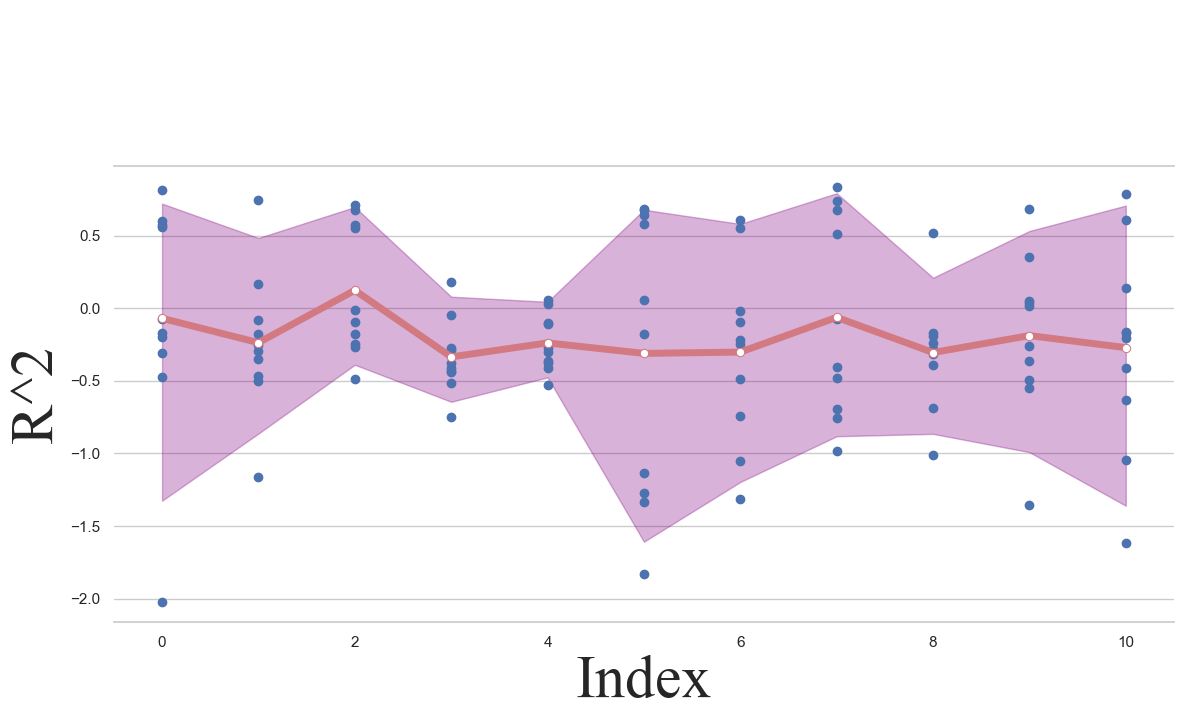

In [32]:
fig_counterfactual(R, metric_name='R^2', dataset_name='WineDataset')

##### AirPassengersDataset

In [19]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

dataset_name = 'AirPassengersDataset'
train, test = datasets['AirPassengersDataset']

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [ ]:
period = 12
std = 0.1*(train.max()-train.min())
num_iteration = int(len(train)/period)

out_counterfactual = {}
MSE =[]
MAE =[]
MAPE = []
R = []

for index in range(num_iteration):
    MSE_tmp =[]
    MAE_tmp =[]
    MAPE_tmp = []
    R_tmp = []
    train_tmp = copy.deepcopy(train)
    loc = index * period
    train_tmp = adding_noise(train_tmp, loc=loc, steps=period, std=std)
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)
        out_counterfactual.update(out_gemini_pro_number)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test, seq_pred)
        mae = mean_absolute_error(test, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test, seq_pred)*100
        r2 = r2_score(test, seq_pred)
    
        MSE_tmp.append(mse)
        MAE_tmp.append(mae)
        MAPE_tmp.append(mape)
        R_tmp.append(r2)
    
    MSE.append(MSE_tmp)
    MAE.append(MAE_tmp)
    MAPE.append(MAPE_tmp)
    R.append(R_tmp)



In [25]:
len(R)

9

C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


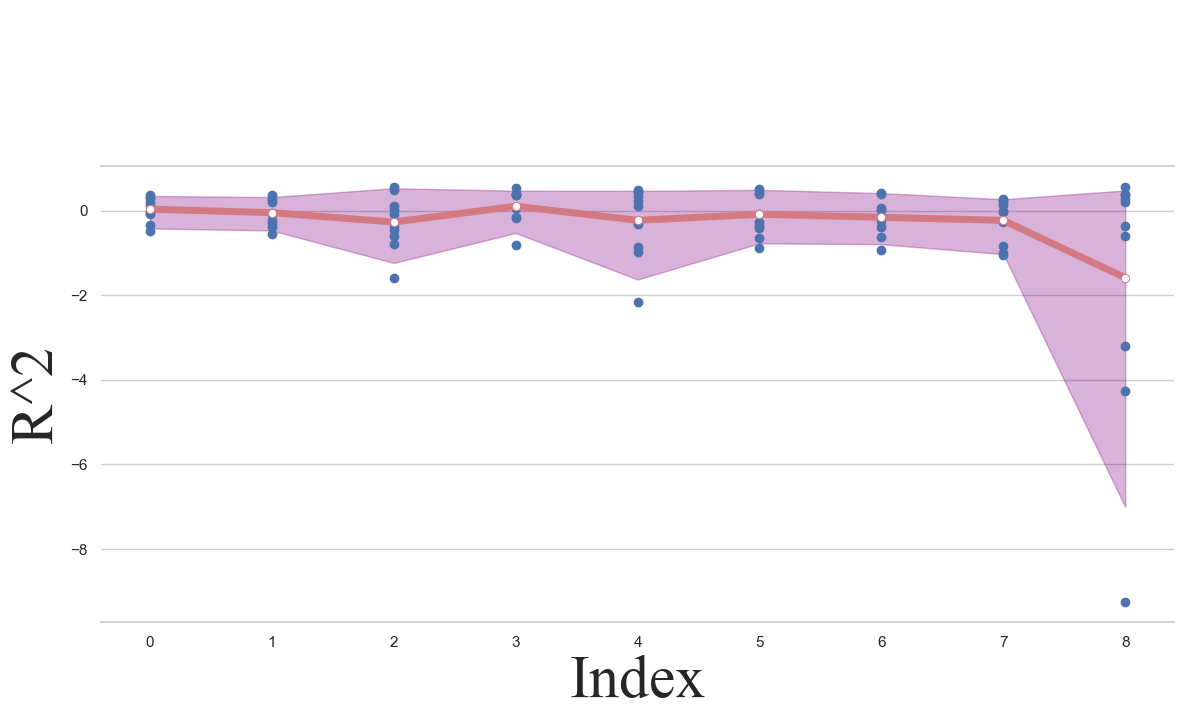

In [26]:
fig_counterfactual(R, metric_name='R^2', dataset_name='AirPassengersDataset')

##### GasRateCO2Dataset

In [83]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

dataset_name = 'GasRateCO2Dataset'
train, test = datasets['GasRateCO2Dataset']

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [ ]:
period = 6  # 这里随便设定
std = 0.1*(train.max()-train.min())
num_iteration = int(len(train)/period)

out_counterfactual = {}
MSE =[]
MAE =[]
MAPE = []
R = []

for index in range(num_iteration):
    MSE_tmp =[]
    MAE_tmp =[]
    MAPE_tmp = []
    R_tmp = []
    train_tmp = copy.deepcopy(train)
    loc = index * period
    train_tmp = adding_noise(train_tmp, loc=loc, steps=period, std=std)
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)
        out_counterfactual.update(out_gemini_pro_number)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test, seq_pred)
        mae = mean_absolute_error(test, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test, seq_pred)*100
        r2 = r2_score(test, seq_pred)
    
        MSE_tmp.append(mse)
        MAE_tmp.append(mae)
        MAPE_tmp.append(mape)
        R_tmp.append(r2)
    
    MSE.append(MSE_tmp)
    MAE.append(MAE_tmp)
    MAPE.append(MAPE_tmp)
    R.append(R_tmp)

C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


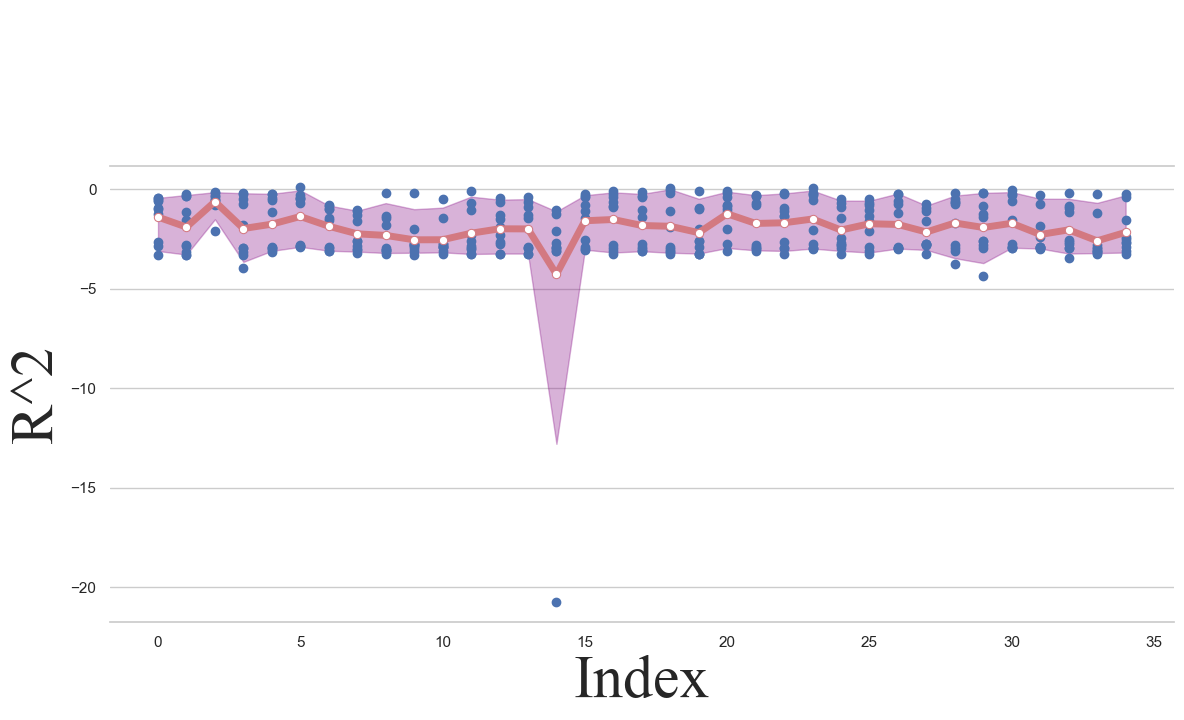

In [91]:
fig_counterfactual(R, metric_name='R^2', dataset_name='IstanbulTraffic')
# 这里应该是GasRateCO2Dataset，还没改(这里最后还差一点没做，不过结论是......前面的内容修改基本没影响

##### Ausbeer

In [69]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

dataset_name = 'AusBeerDataset'
train, test = datasets['AusBeerDataset']

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [ ]:
period = 4
std = 0.1*(train.max()-train.min())
num_iteration = int(len(train)/period)

out_counterfactual = {}
MSE =[]
MAE =[]
MAPE = []
R = []

for index in range(num_iteration):
    MSE_tmp =[]
    MAE_tmp =[]
    MAPE_tmp = []
    R_tmp = []
    train_tmp = copy.deepcopy(train)
    loc = index * period
    train_tmp = adding_noise(train_tmp, loc=loc, steps=period, std=std)
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)
        out_counterfactual.update(out_gemini_pro_number)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test, seq_pred)
        mae = mean_absolute_error(test, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test, seq_pred)*100
        r2 = r2_score(test, seq_pred)
    
        MSE_tmp.append(mse)
        MAE_tmp.append(mae)
        MAPE_tmp.append(mape)
        R_tmp.append(r2)
    
    MSE.append(MSE_tmp)
    MAE.append(MAE_tmp)
    MAPE.append(MAPE_tmp)
    R.append(R_tmp)

C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


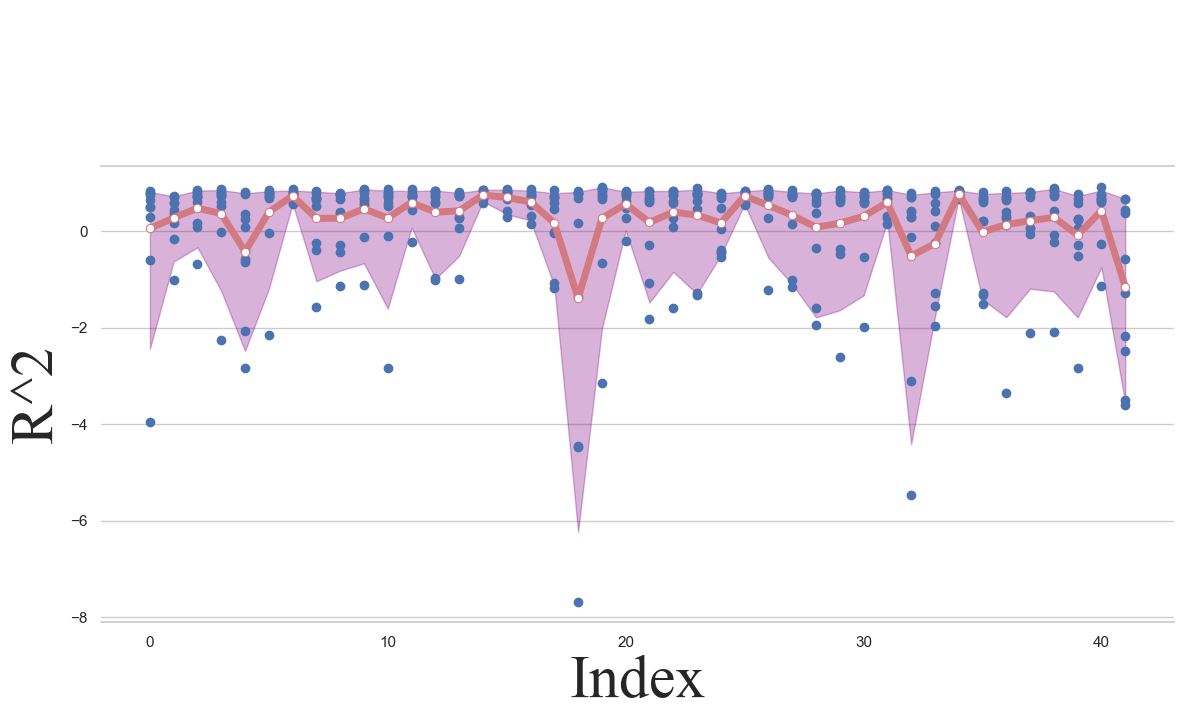

In [72]:
fig_counterfactual(R, metric_name='R^2', dataset_name='AirPassengersDataset')